<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

This notebook contains all functions related to searching and getting peptide-spectrum-matches (PSMs). When searching, we compare how similar an experimental spectrum is to a theoretical spectrum. As described in the FASTA notebook, we can calculate theoretical fragment masses for a given peptide sequence and get theoretical spectra. Typically, we calculate a database with all possible spectra, save it to disk, and then compare our experimental data. This allows re-using the database and saving time for this computational step. It could be that the database is too large to be saved on disc; in this case, generate the database on the fly, referring to only have a subset of all FASTA entries in memory and processing them.

## Comparing spectra

To efficiently compare two spectra, we use a pointer based approach. We start with two sorted arrays, the `query_frag` that contains the m/z positions of the experimental query spectrum and the `db_frag` which contains the database fragment that is compared against to. The two pointers compare each m/z position with each other and check wheter they are within a certain tolerance `frag_tol`. Depending on their delta, either of the pointers is advanced. The function returns an arrray named `hits` that is the same length as the database spectrum and encodes the hit positions.

In [1]:
#| echo: false
#| output: asis
show_doc(compare_frags)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/search.py#L15){target="_blank" style="float:right; font-size:smaller"}

### compare_frags

>      compare_frags (query_frag:numpy.ndarray, db_frag:numpy.ndarray,
>                     frag_tol:float, ppm:bool=False)

Compare query and database frags and find hits

Args:
    query_frag (np.ndarray): Array with query fragments.
    db_frag (np.ndarray): Array with database fragments.
    frag_tol (float): Fragment tolerance for search.
    ppm (bool, optional): Use ppm as unit or Dalton. Defaults to False.

Returns:
    np.ndarray: Array with reported hits.

In [2]:
import numpy as np
query_frag = np.array([100, 200, 300, 400])
db_frag = np.array([150, 200, 300, 450])

# Hits: Query 2 -> Db 2 and Query 3 -> Db 3

compare_frags(query_frag, db_frag, frag_tol=1)

array([0, 2, 3, 0], dtype=int16)

This function allows us to easily compare a query spectrum against a spectrum from a theoretical database.

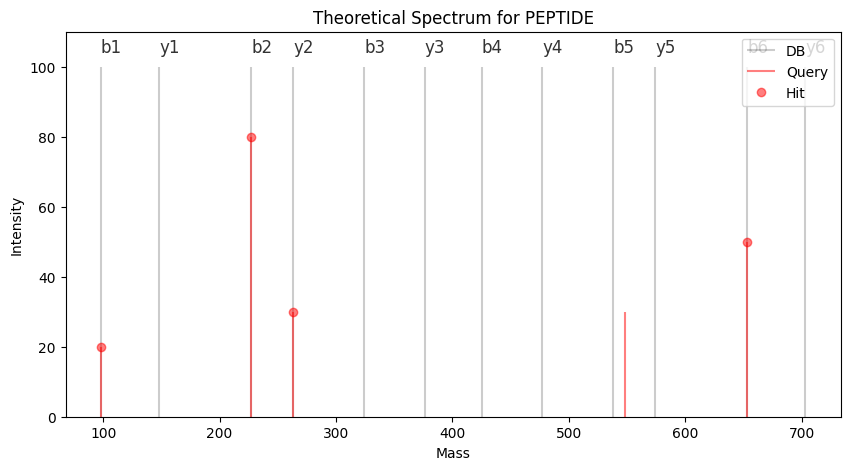

In [ ]:
import matplotlib.pyplot as plt
from alphapept import constants
from alphapept.fasta import get_frag_dict, parse
import alphapept.io
import numpy as np


peptide = 'PEPTIDE'

# Theoretical Spectrum

frag_dict = get_frag_dict(parse(peptide), constants.mass_dict)
db_frag = list(frag_dict.values())
db_frag.sort()

db_int = [100 for _ in db_frag]

# Experimental Spectrum, dummy data

query_frag = np.array([98.06, 227.10, 263.08, 548.06, 653.31])
query_int = np.array([20, 80, 30, 30, 50])

hits = compare_frags(query_frag, db_frag, frag_tol=1)

hitpos = hits[hits > 0] - 1
hit_x = query_frag[hitpos]
hit_y = query_int[hitpos]


plt.figure(figsize=(10,5))
plt.vlines(db_frag, 0, db_int, "k", label="DB", alpha=0.2)
plt.vlines(query_frag, 0, query_int, "r", label="Query", alpha=0.5)

plt.plot(hit_x, hit_y, "ro", label="Hit", alpha=0.5)

for _ in frag_dict.keys():
    plt.text(frag_dict[_], 104, _, fontsize=12, alpha = 0.8)
    
plt.title('Theoretical Spectrum for {}'.format(peptide))
plt.xlabel('Mass')
plt.ylabel('Intensity')
plt.legend()
plt.ylim([0,110])
plt.show()

## Comparing Spectra

To compare multiple spectra against a database, we first need some helper functions. First, we need a conversion function to convert from Dalton masses to ppm, which is implemented in the [`ppm_to_dalton`](https://mannlabs.github.io/alphapept/search.html#ppm_to_dalton) function. 

To minimize the search space, we typically only compare spectra with precursors in the same mass range as defined by `prec_tol`. To look up the limits for search, we define the function [`get_idxs`](https://mannlabs.github.io/alphapept/search.html#get_idxs), which is a wrapper to the fast `searchsorted` method from `NumPy`.

The actual search takes place in [`compare_spectrum_parallel`](https://mannlabs.github.io/alphapept/search.html#compare_spectrum_parallel), which utilizes the performance decorator from the performance notebook. Here we save the top matching spectra for each query spectrum. Note that for code compilation reasons, the code of the previously defined function [`compare_frags`](https://mannlabs.github.io/alphapept/search.html#compare_frags) is duplicated in here. 

In [3]:
#| echo: false
#| output: asis
show_doc(ppm_to_dalton)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/search.py#L55){target="_blank" style="float:right; font-size:smaller"}

### ppm_to_dalton

>      ppm_to_dalton (mass:float, prec_tol:int)

Function to convert ppm tolerances to Dalton.

Args:
    mass (float): Base mass.
    prec_tol (int): Tolerance.

Returns:
    float: Tolerance in Dalton.

In [4]:
#| echo: false
#| output: asis
show_doc(get_idxs)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/search.py#L68){target="_blank" style="float:right; font-size:smaller"}

### get_idxs

>      get_idxs (db_masses:numpy.ndarray, query_masses:numpy.ndarray,
>                prec_tol:float, ppm:bool)

Function to get upper and lower limits to define search range for a given precursor tolerance.

Args:
    db_masses (np.ndarray): Array containing database masses.
    query_masses (np.ndarray): Array containing query masses.
    prec_tol (float): Precursor tolerance for search.
    ppm: Flag to use ppm instead of Dalton.

Returns:
    (np.ndarray, np.ndarray): Indices to lower and upper bounds.

In [5]:
#| echo: false
#| output: asis
show_doc(compare_spectrum_parallel)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/search.py#L95){target="_blank" style="float:right; font-size:smaller"}

### compare_spectrum_parallel

>      compare_spectrum_parallel (query_idx:int, query_masses:numpy.ndarray,
>                                 idxs_lower:numpy.ndarray,
>                                 idxs_higher:numpy.ndarray,
>                                 query_indices:numpy.ndarray,
>                                 query_frags:numpy.ndarray,
>                                 query_ints:numpy.ndarray,
>                                 db_indices:numpy.ndarray,
>                                 db_frags:numpy.ndarray,
>                                 best_hits:numpy.ndarray, score:numpy.ndarray,
>                                 frag_tol:float, ppm:bool)

Compares a spectrum and writes to the best_hits and score.

Args:
    query_idx (int): Integer to the query_spectrum that should be compared.
    query_masses (np.ndarray): Array with query masses.
    idxs_lower (np.ndarray): Array with indices for lower search boundary.
    idxs_higher (np.ndarray): Array with indices for upper search boundary.
    query_indices (np.ndarray): Array with indices to the query data.
    query_frags (np.ndarray): Array with frag types of the query data.
    query_ints (np.ndarray): Array with fragment intensities from the query.
    db_indices (np.ndarray):  Array with indices to the database data.
    db_frags (np.ndarray): Array with frag types of the db data.
    best_hits (np.ndarray): Reporting array which stores indices to the best hits.
    score (np.ndarray): Reporting array that stores the scores of the best hits.
    frag_tol (float): Fragment tolerance for search.
    ppm (bool): Flag to use ppm instead of Dalton.

## Wrapper

To conveniently perform peptide-spectrum matches on multiple datasets we define a wrapper [`get_psms`](https://mannlabs.github.io/alphapept/search.html#get_psms) that returns the PSMS when handing over `query_data` and `db_data`.

In [6]:
#| echo: false
#| output: asis
show_doc(query_data_to_features)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/search.py#L191){target="_blank" style="float:right; font-size:smaller"}

### query_data_to_features

>      query_data_to_features (query_data:dict)

Helper function to extract features from query data.
This is used when the feature finder will not be used.

Args:
    query_data (dict): Data structure containing the query data.

Returns:
    pd.DataFrame: Pandas dataframe so that it can be used for subsequent processing.

In [7]:
#| echo: false
#| output: asis
show_doc(get_psms)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/search.py#L218){target="_blank" style="float:right; font-size:smaller"}

### get_psms

>      get_psms (query_data:dict, db_data:dict,
>                features:pandas.core.frame.DataFrame, parallel:bool,
>                frag_tol:float, prec_tol:float, ppm:bool, min_frag_hits:int,
>                callback:Callable=None, prec_tol_calibrated:float=None,
>                frag_tol_calibrated:float=None, **kwargs)

[summary]

Args:
    query_data (dict): Data structure containing the query data.
    db_data (dict): Data structure containing the database data.
    features (pd.DataFrame): Pandas dataframe containing feature data.
    parallel (bool): Flag to use parallel processing.
    frag_tol (float): Fragment tolerance for search.
    prec_tol (float): Precursor tolerance for search.
    ppm (bool): Flag to use ppm instead of Dalton.
    min_frag_hits (int): Minimum number of frag hits to report a PSMs.
    callback (Callable, optional): Optional callback. Defaults to None.
    prec_tol_calibrated (float, optional): Precursor tolerance if calibration exists. Defaults to None.
    frag_tol_calibrated (float, optional): Fragment tolerance if calibration exists. Defaults to None.

Returns:
    np.ndarray: Numpy recordarray storing the PSMs.
    int: 0

## Extracting columns for scoring

The basic fragment comparison only counts the number of hits and matched intensity fraction when comparing a theoretical spectrum to an experimental one. Based on this metric, we can drastically reduce the number of candidates one wants to analyze for an in-depth comparison, which requires additional features. The following section describes several functions which extract parameters to compare spectrum matches better.

### Frag Delta

[`frag_delta`](https://mannlabs.github.io/alphapept/search.html#frag_delta) substracts the experimental fragment masses from the theoretical fragment masses for each hit. 

In [8]:
#| echo: false
#| output: asis
show_doc(frag_delta)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/search.py#L358){target="_blank" style="float:right; font-size:smaller"}

### frag_delta

>      frag_delta (query_frag:numpy.ndarray, db_frag:numpy.ndarray,
>                  hits:numpy.ndarray)

Calculates the mass difference for a given array of hits in Dalton and ppm.

Args:
    query_frag (np.ndarray): Array with query fragments.
    db_frag (np.ndarray): Array with database fragments.
    hits (np.ndarray): Array with reported hits.

Returns:
    float: Fragment deltas in Dalton.
    float: Fragment deltas in ppm.

### Intensity Fraction
[`intensity_fraction`](https://mannlabs.github.io/alphapept/search.html#intensity_fraction) calculates the fraction of matched intensity. This refers to the intensity of all hits compared to the intensity of all peaks in the query spectrum.

In [9]:
#| echo: false
#| output: asis
show_doc(intensity_fraction)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/search.py#L379){target="_blank" style="float:right; font-size:smaller"}

### intensity_fraction

>      intensity_fraction (query_int:numpy.ndarray, hits:numpy.ndarray)

Calculate the fraction of matched intensity

Args:
    query_int (np.ndarray): Array with query intensities.
    hits (np.ndarray): Array with reported hits.

Returns:
    float: Fraction of the matched intensity to the total intensity.

### File Format

To have an efficient data format to store PSMs in the search. We use `numpy`-recarrays and define the utility functions [`add_column`](https://mannlabs.github.io/alphapept/search.html#add_column) and [`remove_column`](https://mannlabs.github.io/alphapept/search.html#remove_column) to append and remove data.

In [10]:
#| echo: false
#| output: asis
show_doc(remove_column)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/search.py#L422){target="_blank" style="float:right; font-size:smaller"}

### remove_column

>      remove_column (recarray:numpy.ndarray, name:str)

Function to remove a column from a recarray.

Args:
    recarray (np.ndarray): NumPy record array.
    name (str): Column name of the column to be removed.

Returns:
    np.ndarray: NumPy record array with removed column.

In [11]:
#| echo: false
#| output: asis
show_doc(add_column)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/search.py#L403){target="_blank" style="float:right; font-size:smaller"}

### add_column

>      add_column (recarray:numpy.ndarray, column:numpy.ndarray, name:str)

Function to add a column with given name to recarray

Args:
    recarray (np.ndarray): NumPy record array.
    column (np.ndarray): Data column that should be added to the record array.
    name (str): Name of the column in the new recordarray.

Returns:
    np.ndarray: NumPy recordarray with new field.

## Extracting features for scoring

### Indices

When performing a database search, we need to know which experimental spectrum we compare with what database entry. 
We distinguish three indices:

* query_idx
* raw_idx
* feature_idx

Initially, the get_psms function accepts experimental data in the form of `query_data`. Here, the `query_idx` refers to the index to `query_data`. However, this might not be the same index as the raw data. This is due to the implementation of the matching of MS1-features to MS2 spectra. Here we allow multiple matches and implement this by repeating the respective spectrum. 

We then add the two columns `feature_idx` and `raw_idx` to the PSMs to later be able to distinguish where the match originated. In this case, `raw_idx` refers to the original spectrum.

When not applying feature finding, `raw_idx` and `query_idx` are equivalent.


### Features

In the [`score`](https://mannlabs.github.io/alphapept/search.html#score)-function we use the pre-filtered PSMs to extract additional columns for scoring such as the offset from theoretical to experimental precursor or the number of b- and y-ion hits.

In [12]:
#| echo: false
#| output: asis
show_doc(get_hits)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/search.py#L443){target="_blank" style="float:right; font-size:smaller"}

### get_hits

>      get_hits (query_frag:numpy.ndarray, query_int:numpy.ndarray,
>                db_frag:numpy.ndarray, db_int:numpy.ndarray,
>                frag_type:numpy.ndarray, mtol:float, ppm:bool, losses:list)

Function to extract the types of hits based on a single PSMs.

The reporting array stores information about the matched fragment_ions in a record array.

Args:
    query_frag (np.ndarray): Array with query fragments.
    query_int (np.ndarray): Array with query intensities.
    db_frag (np.ndarray): Array with database fragments.
    db_int (np.ndarray): Array with database intensities.
    frag_type (np.ndarray): Array with fragment types.
    mtol (float): Mass tolerance.
    ppm (bool): Flag to use ppm instead of Dalton.
    losses (list): List of losses.

Returns:
    np.ndarray: NumPy array that stores ion information.

In [13]:
#| echo: false
#| output: asis
show_doc(score)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/search.py#L503){target="_blank" style="float:right; font-size:smaller"}

### score

>      score (psms:numpy.recarray, query_masses:numpy.ndarray,
>             query_masses_raw:numpy.ndarray, query_frags:numpy.ndarray,
>             query_ints:numpy.ndarray, query_indices:numpy.ndarray,
>             db_masses:numpy.ndarray, db_frags:numpy.ndarray,
>             frag_types:numpy.ndarray, mtol:float, db_indices:numpy.ndarray,
>             ppm:bool, psms_dtype:list, db_ints:numpy.ndarray=None,
>             parallel:bool=False)

Function to extract score columns when giving a recordarray with PSMs.

Args:
    psms (np.recarray): Recordarray containing PSMs.
    query_masses (np.ndarray): Array with query masses.
    query_masses_raw (np.ndarray): Array with raw query masses.
    query_frags (np.ndarray): Array with frag types of the query data.
    query_ints (np.ndarray): Array with fragment intensities from the query.
    query_indices (np.ndarray): Array with indices to the query data.
    db_masses (np.ndarray): Array with database masses.
    db_frags (np.ndarray): Array with fragment masses.
    frag_types (np.ndarray): Array with fragment types.
    mtol (float): Mass tolerance.
    db_indices (np.ndarray): Array with indices to the database array.
    ppm (bool): Flag to use ppm instead of Dalton.
    psms_dtype (list): List describing the dtype of the PSMs record array.
    db_ints (np.ndarray, optional): Array with database intensities. Defaults to None.
    parallel (bool, optional): Flag to use parallel processing. Defaults to False.

Returns:
    np.recarray: Recordarray containing PSMs with additional columns.
    np.ndarray: NumPy array containing ion information.

In [14]:
#| echo: false
#| output: asis
show_doc(get_sequences)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/search.py#L613){target="_blank" style="float:right; font-size:smaller"}

### get_sequences

>      get_sequences (psms:numpy.recarray, db_seqs:numpy.ndarray)

Get sequences to add them to a recarray

Args:
    psms (np.recarray): Recordarray containing PSMs.
    db_seqs (np.ndarray): NumPy array containing sequences.

Returns:
    np.ndarray: NumPy array containing a subset of sequences.

In [15]:
#| echo: false
#| output: asis
show_doc(get_score_columns)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/search.py#L631){target="_blank" style="float:right; font-size:smaller"}

### get_score_columns

>      get_score_columns (psms:numpy.recarray, query_data:dict,
>                         db_data:Union[dict,str],
>                         features:pandas.core.frame.DataFrame, parallel:bool,
>                         frag_tol:float, prec_tol:float, ppm:bool,
>                         prec_tol_calibrated:Union[NoneType,float]=None,
>                         frag_tol_calibrated:float=None, **kwargs)

Wrapper function to extract score columns.

Args:
    psms (np.recarray): Recordarray containing PSMs.
    query_data (dict): Data structure containing the query data.
    db_data: Union[dict, str]: Data structure containing the database data or path to database.
    features (pd.DataFrame): Pandas dataframe containing feature data.
    parallel (bool): Flag to use parallel processing.
    frag_tol (float): Fragment tolerance for search.
    prec_tol (float): Precursor tolerance for search.
    ppm (bool): Flag to use ppm instead of Dalton.
    prec_tol_calibrated (Union[None, float], optional): Calibrated offset mass. Defaults to None.
    frag_tol_calibrated (float, optional): Fragment tolerance if calibration exists. Defaults to None.

Returns:
    np.recarray: Recordarray containing PSMs with additional columns.
    np.ndarray: NumPy array containing ion information.

## Plot

In [16]:
#| echo: false
#| output: asis
show_doc(plot_psms)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/search.py#L812){target="_blank" style="float:right; font-size:smaller"}

### plot_psms

>      plot_psms (index, ms_file)

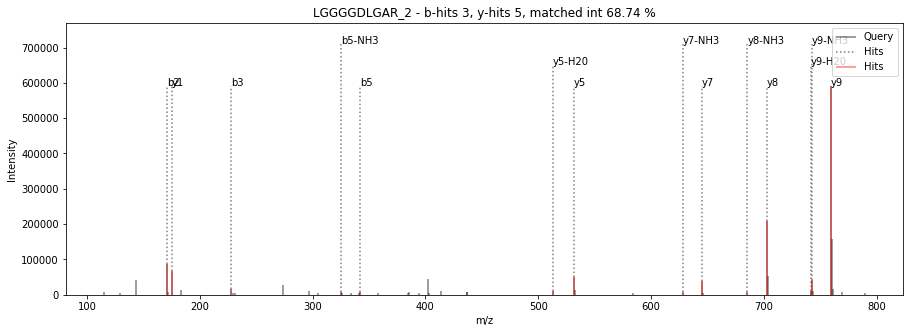

In [ ]:
# Example usage to plot a psms
ms_file = alphapept.io.MS_Data_File('../testfiles/test.ms_data.hdf')
plot_psms(0, ms_file)

## Searching with database

We save intermediate results to hdf5 files

In [17]:
#| echo: false
#| output: asis
show_doc(search_db)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/search.py#L903){target="_blank" style="float:right; font-size:smaller"}

### search_db

>      search_db (to_process:tuple, callback:Callable=None, parallel:bool=False,
>                 first_search:bool=True)

Wrapper function to perform database search to be used by a parallel pool.

Args:
    to_process (tuple): Tuple containing an index to the file and the experiment settings.
    callback (Callable, optional): Callback function to indicate progress. Defaults to None.
    parallel (bool, optional): Flag to use parallel processing. Defaults to False.
    first_search (bool, optional): Flag to indicate this is the first search. Defaults to True.

Returns:
    Union[bool, str]: Returns True if the search was successfull, otherwise returns a string containing the Exception.

In [18]:
#| echo: false
#| output: asis
show_doc(store_hdf)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/search.py#L876){target="_blank" style="float:right; font-size:smaller"}

### store_hdf

>      store_hdf (df:pandas.core.frame.DataFrame, path:str, key:str,
>                 replace:bool=False, swmr:bool=False)

Wrapper function to store a DataFrame in an hdf.

Args:
    df (pd.DataFrame): DataFrame to be stored.
    path (str): Target path of the hdf file.
    key (str): Name of the field to be saved.
    replace (bool, optional): Flag whether the field should be replaced.. Defaults to False.
    swmr (bool, optional): Flag to use swmr(single write multiple read)-mode. Defaults to False.

## Searching Large Fasta and or Search Space

In [19]:
#| echo: false
#| output: asis
show_doc(search_fasta_block)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/search.py#L994){target="_blank" style="float:right; font-size:smaller"}

### search_fasta_block

>      search_fasta_block (to_process:tuple)

Search fasta block. This file digests per block and does not use a saved database.
For searches with big fasta files or unspecific searches.

Args:
    to_process (tuple): Tuple containing a fasta_index, fasta_block, a list of files and a list of experimental settings.

Returns:
    list: A list of dataframes when searching the respective file.
    int: Number of new peptides that were generated in this iteration.

In [20]:
#| echo: false
#| output: asis
show_doc(filter_top_n)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/search.py#L1105){target="_blank" style="float:right; font-size:smaller"}

### filter_top_n

>      filter_top_n (temp:pandas.core.frame.DataFrame, top_n:int=10)

Takes a dataframe and keeps only the top n entries (based on hits).
Combines fasta indices for sequences.

Args:
    temp (pd.DataFrame): Pandas DataFrame containing PSMs.
    top_n (int, optional): Number of top-n entries to be kept. Defaults to 10.

Returns:
    pd.DataFrame: Filtered DataFrame.

In [21]:
#| echo: false
#| output: asis
show_doc(search_parallel)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/search.py#L1199){target="_blank" style="float:right; font-size:smaller"}

### search_parallel

>      search_parallel (settings:dict, calibration:Union[list,NoneType]=None,
>                       fragment_calibration:Union[list,NoneType]=None,
>                       callback:Union[Callable,NoneType]=None)

Function to search multiple ms_data files in parallel.
This function will additionally calculate fragments and precursor masses from a given FASTA file.

Args:
    settings (dict): Settings file containg the experimental definitions.
    calibration (Union[list, None], optional): List of calibrated offsets. Defaults to None.
    fragment_calibration (Union[list, None], optional): List of calibrated fragment offsets. Defaults to None.
    callback (Union[Callable, None], optional): Callback function. Defaults to None.

Returns:
    dict: FASTA dictionary.

In [22]:
#| echo: false
#| output: asis
show_doc(ion_extractor)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/search.py#L1143){target="_blank" style="float:right; font-size:smaller"}

### ion_extractor

>      ion_extractor (df:pandas.core.frame.DataFrame, ms_file, frag_tol:float,
>                     ppm:bool)

Extracts the matched hits (fragment_ions) from a dataframe.

Args:
    df (pd.DataFrame): Pandas dataframe containing the results of the first search.
    ms_file : MsFile
    frag_tol (float): Fragment tolerance for search.
    ppm (bool): Flag to use ppm instead of Dalton.

Returns:
    np.ndarray: Numpy recordarray storing the PSMs.
    np.ndarray: Numpy recordarray storing the fragment_ions.